# 2D variability analysis for HBEC IFN experiment

In [108]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
import itertools
import functools
%matplotlib inline

In [109]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg')
sys.path.append('/data/home/Github/misc-seq/miscseq/')
import encode
import memento

In [110]:
data_path = '/data_volume/ifn_hbec/'

### Get the TFs

In [111]:
tf_df = pd.read_csv('DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [112]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [113]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [114]:
adata.shape

(69958, 36588)

### Setup memento

In [115]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [116]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [117]:
memento.setup_memento(adata, q_column='q')

In [118]:
adata.obs.head(3)

,NUM.SNPS,BEST.GUESS,DROPLET.TYPE,batch,HTO_classification,condition,donor,stim,time,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell_type,q,memento_size_factor
AAACCCAAGGAAGTAG-1,1700,donor0,SNG,0,hash-10,d2513_lambda_9,d2513,lambda,9,4297,4297,12191.0,1394.0,11.434665,3,ciliated,0.10425,0.955289
AAACCCAAGGGACTGT-1,839,donor0,SNG,0,hash-3,d2513_alpha_24,d2513,alpha,24,2171,2171,7270.0,386.0,5.309491,5,bc,0.10425,0.824407
AAACCCACAATCTGCA-1,1130,donor1,SNG,0,hash-1,d2614_alpha_3,d2614,alpha,3,3016,3016,9544.0,516.0,5.406538,0,basal,0.10425,0.988939


### Get TFs

In [119]:
condensed_tfs = []
for tf in tfs:
    if 'STAT' in tf:
        condensed_tfs.append(tf)
    elif 'IRF' in tf:
        condensed_tfs.append(tf)
    elif 'NFKB' in tf:
        condensed_tfs.append(tf)
    elif 'JUN' in tf:
        condensed_tfs.append(tf)
    elif 'MYC' in tf:
        condensed_tfs.append(tf)
    elif 'FOS' in tf:
        condensed_tfs.append(tf)
    else:
        continue

In [120]:
cts = [['ciliated'], ['bc'], ['basal']]
tps = ['0','3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

### Compute some 1D moments

In [121]:
mean_data_dict = {}
var_data_dict = {}
for ct in [['bc']]:
    for stim in ['beta']:
        
        mean_df_list = []
        var_df_list = []

        for tp in tps:
            
            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin([tp]), :].copy()
            time_converter={int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)

            mean, var = memento.get_1d_moments(adata_stim, groupby='time_step')
            mean_df_list.append(mean.rename(columns={'time_step_1':('tp_'+str(tp))}))
            var_df_list.append(var.rename(columns={'time_step_1':('tp_'+str(tp))}))
        mean_data_dict['-'.join(ct)+'-'+stim] = functools.reduce(lambda x, y: pd.merge(x, y, on='gene', how='inner'), mean_df_list)
        var_data_dict['-'.join(ct)+'-'+stim] = functools.reduce(lambda x, y: pd.merge(x, y, on='gene', how='inner'), var_df_list)


In [122]:
# Plot
adata_processed = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [155]:
adata_processed_subset = adata_processed[adata.obs.cell_type.isin(['bc']) & adata.obs.stim.isin(['alpha', 'beta'])]

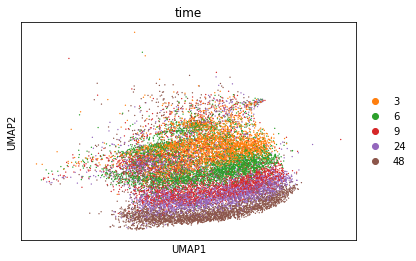

In [156]:
sc.pl.umap(adata_processed_subset, color='time', use_raw=False)

Trying to set attribute `.obs` of view, copying.


0.1761084
0.20206857
0.23712072
0.23814064
0.14714989


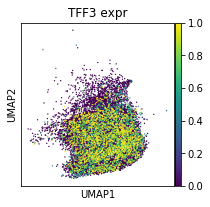

In [157]:
gene = 'ACE2'
expr = adata_processed_subset.raw[:, gene].X.toarray().reshape(-1)
for tp in [3, 6, 9, 24, 48]:
    
    lower = expr[(adata_processed_subset.obs.time == str(tp)).values].min()
    upper = (expr[(adata_processed_subset.obs.time == str(tp)).values] - lower).max()
#     expr[adata_processed_subset.obs.time == str(tp)] -= expr[adata_processed_subset.obs.time == str(tp)].mean()#(expr[(adata_processed_subset.obs.time == str(tp)).values]-lower)/upper
    
    print(expr[adata_processed_subset.obs.time == str(tp)].mean())
adata_processed_subset.obs['TFF3 expr'] = expr
fig, ax = plt.subplots(figsize=(3,3))
sc.pl.umap(adata_processed_subset, color='TFF3 expr', use_raw=True, vmin=0, vmax=1, ax=ax)


In [158]:
mean_data_dict['bc-beta'].query('gene == "ACE2"')

,gene,tp_0,tp_3,tp_6,tp_9,tp_24,tp_48


In [134]:
var_data_dict['bc-beta'].query('gene == "TFF3"')

,gene,tp_0,tp_3,tp_6,tp_9,tp_24,tp_48
6570,TFF3,3.19836,3.022296,3.803839,4.073118,4.284854,4.497706


In [133]:
rhos= []
for idx, row in var_data_dict['bc-beta'].iterrows():
    
    x = np.arange(5)
    y = np.array([row['tp_' + str(tp)] for tp in [3, 6, 9, 24, 48]])
    
    rho = stats.pearsonr(x,y)[0]
    rhos.append(rho)
    if abs(y[-1]-y[0]) >2:
        gene = row['gene']
        expr = adata_processed_subset.raw[:, gene].X.toarray().reshape(-1)
        for tp in [3, 6, 9, 24, 48]:

            lower = expr[(adata_processed_subset.obs.time == str(tp)).values].min()
            upper = (expr[(adata_processed_subset.obs.time == str(tp)).values] - lower).max()
            expr[adata_processed_subset.obs.time == str(tp)] -= expr[adata_processed_subset.obs.time == str(tp)].mean()#(expr[(adata_processed_subset.obs.time == str(tp)).values]-lower)/upper
        adata_processed_subset.obs['expr'] = expr
        sc.pl.umap(adata_processed_subset, color='expr', use_raw=True, vmin=0, vmax=1, save='_{}.png'.format(gene), show=False)

In [23]:
rhos

[-0.12911592482100626]

### Plotting

### Read the correlation data

In [15]:
data_dict = {}
for ct in cts:
    for stim in stims:
        
        df_list = []

        for tp in tps:
            
            fname = '{}_{}_{}.csv'.format('-'.join(ct), stim, tp)
            
            df = pd.read_csv('/data_volume/ifn_hbec/tf_corr_deep/' + fname).rename(columns={'time_step_1':('tp_'+str(tp))})
            df_list.append(df)
            
        data_dict['-'.join(ct)+'-'+stim] = functools.reduce(lambda x, y: pd.merge(x, y, on=['gene_1', 'gene_2'], how='inner'), df_list)
        

### Correlate the change in variance of a gene with change in variance of a TF

In [248]:
ct = 'ciliated'
stim = 'gamma'

In [249]:
for tf in data_dict[ct + '-' + stim].gene_1.drop_duplicates().tolist():
    
    potential_targets = data_dict[ct + '-' + stim].query('gene_1 == "{}" & gene_2 != "{}"'.format(tf, tf)).copy()
    potential_targets['mean_corr'] = potential_targets.iloc[2:].mean(axis=1)
    genes = potential_targets.query('mean_corr > 0.4').gene_2.tolist()
    
    tf_vars = var_data_dict[ct + '-' + stim].query('gene == "{}"'.format(tf)).iloc[0, 1:].values
    
    for gene in genes:
        
        gene_vars = var_data_dict[ct + '-' + stim].query('gene == "{}"'.format(gene)).iloc[0, 1:].values
        
        r = stats.pearsonr(tf_vars, gene_vars)
        if r[0] > 0.9:
        
            print(tf, gene, r)
    

STAT2 RANGAP1 (0.9174907920868045, 0.009930802255662986)
IRF7 IFI44 (0.917814117631768, 0.00985421582826264)
IRF7 DDX58 (0.9643415417932077, 0.0018846181405518703)
IRF7 IFIT2 (0.903579035012743, 0.013497290757868059)
IRF7 MX2 (0.9733055969274066, 0.0010593756353389926)
JUNB UBC (0.9017184407176103, 0.014014233534766784)
JUNB ZFP36 (0.9350414762806732, 0.006192364893928466)
FOSL2 PTP4A2 (0.9228696218927426, 0.008694214858326664)
IRF3 LY75 (0.9278934320384793, 0.007611581815183305)
IRF2 SSR3 (0.9660385182410204, 0.0017104880798903617)
IRF2 HMGN3 (0.9104346085103331, 0.011673694064076685)
IRF2 PSMA2 (0.9348804808898676, 0.0062227563077184985)
IRF2 RAB2A (0.9518407341832136, 0.0034231240750118605)
IRF2 VPS29 (0.9717477326463458, 0.0011860105686682893)
IRF2 SNX6 (0.9116488486365935, 0.011364057648411308)
IRF2 RPS15 (0.9718022788906931, 0.0011814570478152534)
IRF2 SNAP29 (0.9303164125585751, 0.007114518673929455)
IRF1 GBP1 (0.9372852593990271, 0.0057763751466678994)
IRF1 PARP9 (0.94778550986

In [51]:
stats.pearsonr(tf_vars, gene_vars)

(0.48018549393962046, 0.33508189057305465)

In [40]:
tf_vars

array([0.3837928007433655, 0.9247314870809124, 1.0949091971928355,
       1.3554829868547327, 0.7710150951334724, 0.6569686850118337],
      dtype=object)

In [25]:
genes

,gene_1,gene_2,tp_0,tp_3,tp_6,tp_9,tp_24,tp_48,mean_corr
48464,MYC,RPL22,0.071167,0.313170,0.398885,0.335328,0.439229,0.369946,0.321288
48475,MYC,ERRFI1,0.462104,0.146869,0.427464,0.270125,0.280524,0.534802,0.353648
48531,MYC,ECE1,0.546766,0.273501,0.463910,0.279080,0.401145,0.466993,0.405233
48539,MYC,HNRNPR,0.115325,0.248282,0.477756,0.482332,0.297968,0.419297,0.340160
48541,MYC,TCEA3,0.312770,0.335760,0.279707,0.129686,0.396378,0.481626,0.322654
...,...,...,...,...,...,...,...,...,...
56380,MYC,MAGT1,0.022336,0.424184,0.209409,0.459745,0.206918,0.565389,0.314664
56396,MYC,RPL36A,0.126818,0.474201,0.416925,0.444600,0.389718,0.557537,0.401633
56407,MYC,BEX3,0.155495,0.563268,0.398978,0.227521,0.096595,0.515301,0.326193
56433,MYC,RPL39,0.083483,0.262682,0.366446,0.458420,0.430052,0.469362,0.345074


### Positive autoregulation

In [251]:
ct = ['ciliated']
stim = 'gamma'

In [252]:
genes = ['STAT1', 'GBP1', 'PSMB9', 'TRIM69']
var_mat = np.zeros((len(genes), 6))
var_se_mat = np.zeros((len(genes), 6))

for i, tp in enumerate(tps):
    adata_stim = adata.copy()[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.stim.isin(['control', stim]) & \
        adata.obs.time.isin([tp]), :].copy()
    time_converter={int(tp):1}
    adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])
    adata_stim = adata_stim[:, genes].copy()
    memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=0)
    memento.ht_1d_moments(adata_stim, formula_like='1', cov_column='Intercept')
    mean, var = memento.get_1d_moments(adata_stim, groupby='time_step')
    ht_df = memento.get_1d_ht_result(adata_stim)
    
    var_mat[:, i] = var['time_step_1'].values
    var_se_mat[:, i] = ht_df['dv_se'].values
    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log
/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log
[Parallel(n_jobs=1)]:

In [246]:
var_mat.shape

(5, 6)

In [260]:
var_mat[0, 1]

-0.9219309946915545

In [273]:
var_se_mat

array([[0.19616882, 0.11817248, 0.09152158, 0.08287253, 0.06450908,
        0.08318293],
       [0.3037785 , 0.08879454, 0.08417513, 0.06720553, 0.06817424,
        0.07775142],
       [0.22405719, 0.06684452, 0.06554786, 0.06844078, 0.05946119,
        0.08550457],
       [0.49188259, 0.64613249, 0.32979958, 0.28388936, 0.32044942,
        0.20176784]])

([<matplotlib.axis.XTick at 0x7fc30d0a0950>,
 <a list of 6 Text xticklabel objects>)

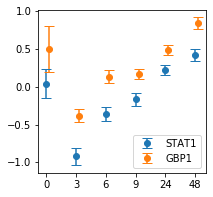

In [282]:
plt.figure(figsize=(3, 3))
x = np.arange(1, 7)
plt.errorbar(x, var_mat[0, :], yerr=var_se_mat[0, :], fmt='o', capsize=5)
plt.errorbar(x+0.1, var_mat[1, :], yerr=var_se_mat[1, :], fmt='o', capsize=5)
plt.legend(['STAT1', 'GBP1'])
plt.xticks(x, tps)
# plt.scatter(x, var_mat[2, 1:])
# plt.scatter(x, var_mat[3, 1:]/var_mat[3, 1])